# JAXPeriodicRegressor: Periodic Neural Networks with Uncertainty

This notebook demonstrates using Periodic Neural Networks for regression tasks where inputs have known periodicity, such as angles, phases, or cyclic time features.

## What are Periodic Neural Networks?

Periodic Neural Networks use **Fourier feature expansion** to capture periodic patterns. For a feature $x$ with period $T$, we expand it as:

$$\phi(x) = [\sin(2\pi x/T), \cos(2\pi x/T), \sin(4\pi x/T), \cos(4\pi x/T), \ldots]$$

This representation guarantees that the network output is **exactly periodic** with period $T$:

$$f(x + T) = f(x) \quad \text{for all } x$$

## When to Use Periodic Neural Networks

Periodic features arise naturally in many domains:

| Domain | Example | Period |
|--------|---------|--------|
| Chemistry | Dihedral angles | $2\pi$ |
| Materials | Crystallographic angles | $2\pi$ or lattice-specific |
| Time series | Hour of day | 24 hours |
| Time series | Day of year | 365 days |
| Physics | Phase angles | $2\pi$ |
| Signal processing | Wave phases | Signal-specific |

## References

- Rahimi, A., & Recht, B. (2007). "Random Features for Large-Scale Kernel Machines." NIPS.
- Tancik, M., et al. (2020). "Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains." NeurIPS.

## LLPR Uncertainty Quantification

This implementation includes **Last-Layer Prediction Rigidity (LLPR)** for uncertainty quantification:

- Bigi, F., Chong, S., Ceriotti, M., & Grasselli, F. (2024). "A prediction rigidity formalism for low-cost uncertainties in trained neural networks." Machine Learning: Science and Technology.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import os

os.environ["JAX_PLATFORM_NAME"] = "cpu"

from pycse.sklearn.jax_periodic import JAXPeriodicRegressor

# Set random seed for reproducibility
np.random.seed(42)

## How Fourier Features Guarantee Periodicity

### The Key Insight

The trigonometric functions $\sin$ and $\cos$ are periodic with period $2\pi$. By computing:

$$\sin(2\pi x / T) \quad \text{and} \quad \cos(2\pi x / T)$$

we get functions that are periodic with period $T$:

$$\sin(2\pi(x+T)/T) = \sin(2\pi x/T + 2\pi) = \sin(2\pi x/T)$$

### Multiple Harmonics

Using multiple harmonics allows the network to capture complex periodic patterns:

$$\phi(x) = [\sin(\omega x), \cos(\omega x), \sin(2\omega x), \cos(2\omega x), \ldots, \sin(n\omega x), \cos(n\omega x)]$$

where $\omega = 2\pi/T$ is the fundamental frequency.

**More harmonics = more complex patterns, but also more parameters and potential overfitting.**

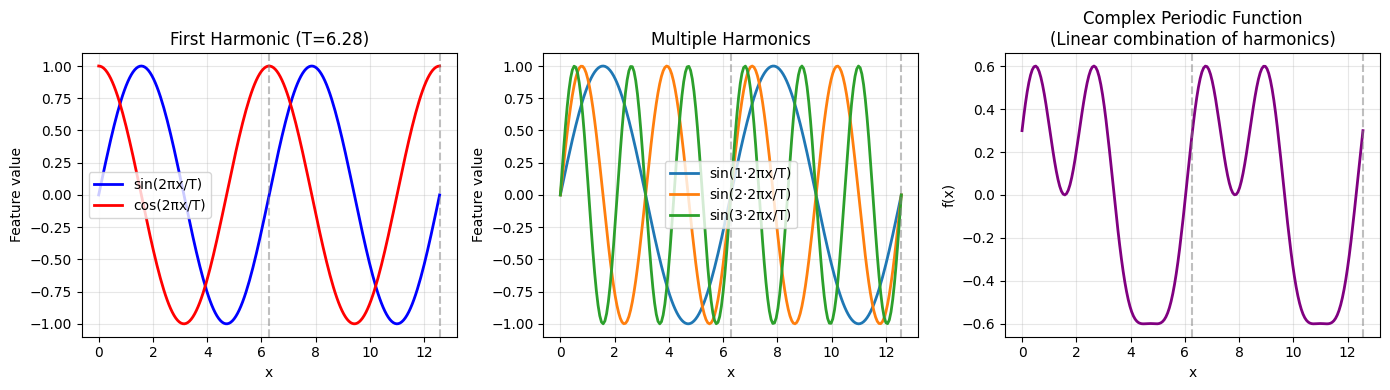

Key insight: Any periodic function with period T can be approximated
by a linear combination of sin and cos at harmonics of T.


In [2]:
# Visualize Fourier features
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 1. Single harmonic
x = np.linspace(0, 4 * np.pi, 200)
T = 2 * np.pi

ax = axes[0]
ax.plot(x, np.sin(2 * np.pi * x / T), "b-", linewidth=2, label="sin(2πx/T)")
ax.plot(x, np.cos(2 * np.pi * x / T), "r-", linewidth=2, label="cos(2πx/T)")
ax.axvline(T, color="gray", linestyle="--", alpha=0.5)
ax.axvline(2 * T, color="gray", linestyle="--", alpha=0.5)
ax.set_xlabel("x")
ax.set_ylabel("Feature value")
ax.set_title(f"First Harmonic (T={T:.2f})")
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Multiple harmonics
ax = axes[1]
for n in range(1, 4):
    ax.plot(x, np.sin(2 * np.pi * n * x / T), linewidth=2, label=f"sin({n}·2πx/T)")
ax.axvline(T, color="gray", linestyle="--", alpha=0.5)
ax.axvline(2 * T, color="gray", linestyle="--", alpha=0.5)
ax.set_xlabel("x")
ax.set_ylabel("Feature value")
ax.set_title("Multiple Harmonics")
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Complex periodic function from harmonics
ax = axes[2]
complex_periodic = (
    0.5 * np.sin(2 * np.pi * x / T)
    + 0.3 * np.cos(4 * np.pi * x / T)
    + 0.2 * np.sin(6 * np.pi * x / T)
)
ax.plot(x, complex_periodic, "purple", linewidth=2)
ax.axvline(T, color="gray", linestyle="--", alpha=0.5)
ax.axvline(2 * T, color="gray", linestyle="--", alpha=0.5)
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
ax.set_title("Complex Periodic Function\n(Linear combination of harmonics)")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key insight: Any periodic function with period T can be approximated")
print("by a linear combination of sin and cos at harmonics of T.")

## 1. Basic Usage: Learning a Sine Function

Let's start with a simple example: learning $y = \sin(x)$ from noisy data.

In [3]:
# Generate data from a simple periodic function
np.random.seed(42)
n_samples = 150

# Sample within one period, but we want to extrapolate to multiple periods
X_train_range = np.random.uniform(0, 2 * np.pi, (n_samples, 1))
y_train_range = np.sin(X_train_range[:, 0]) + 0.1 * np.random.randn(n_samples)

print(f"Training samples: {n_samples}")
print("Training range: [0, 2π]")

Training samples: 150
Training range: [0, 2π]


In [4]:
# Train periodic model
model = JAXPeriodicRegressor(
    hidden_dims=(32, 32),
    periodicity={0: 2 * np.pi},  # Feature 0 has period 2π
    n_harmonics=5,
    epochs=500,
    random_state=42,
    verbose=True,
)
model.fit(X_train_range, y_train_range)

print(f"\nNumber of expanded features: {model.n_expanded_features_}")
print("  (5 harmonics × 2 [sin+cos] = 10 features)")

Epoch 100/500, Loss: 0.018981
Epoch 200/500, Loss: 0.016369
Epoch 300/500, Loss: 0.017531
Epoch 400/500, Loss: 0.017811
Epoch 500/500, Loss: 0.017231
LLPR calibrated: α²=4.28e-02, ζ²=5.46e-02, NLL=-1.1327

Number of expanded features: 10
  (5 harmonics × 2 [sin+cos] = 10 features)


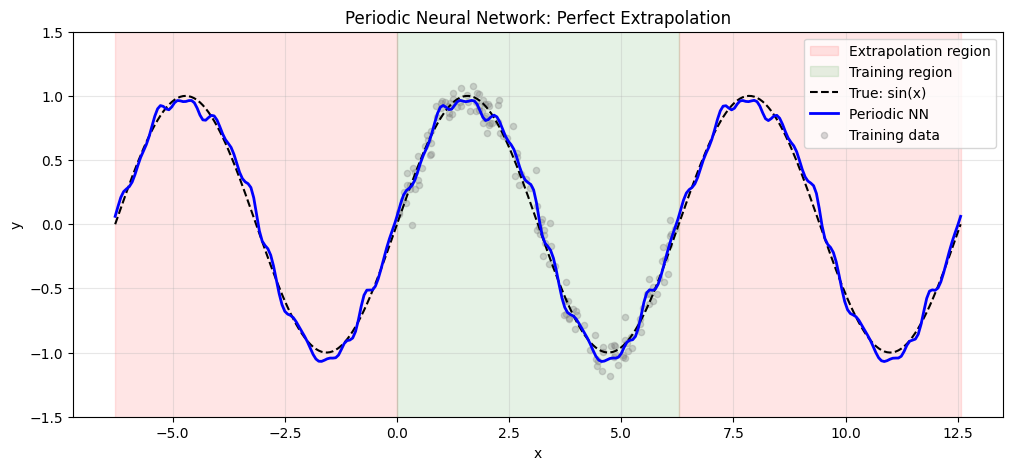

Notice: The model perfectly extrapolates outside the training region!
This is because periodicity is built into the representation.


In [5]:
# Test periodicity by predicting over multiple periods
X_test_extended = np.linspace(-2 * np.pi, 4 * np.pi, 300).reshape(-1, 1)
y_pred_extended = model.predict(X_test_extended)
y_true = np.sin(X_test_extended[:, 0])

plt.figure(figsize=(12, 5))

plt.fill_between([-2 * np.pi, 0], -2, 2, alpha=0.1, color="red", label="Extrapolation region")
plt.fill_between([2 * np.pi, 4 * np.pi], -2, 2, alpha=0.1, color="red")
plt.fill_between([0, 2 * np.pi], -2, 2, alpha=0.1, color="green", label="Training region")

plt.plot(X_test_extended, y_true, "k--", linewidth=1.5, label="True: sin(x)")
plt.plot(X_test_extended, y_pred_extended, "b-", linewidth=2, label="Periodic NN")
plt.scatter(X_train_range, y_train_range, alpha=0.3, c="gray", s=20, label="Training data")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Periodic Neural Network: Perfect Extrapolation")
plt.legend(loc="upper right")
plt.ylim(-1.5, 1.5)
plt.grid(True, alpha=0.3)
plt.show()

print("Notice: The model perfectly extrapolates outside the training region!")
print("This is because periodicity is built into the representation.")

In [6]:
# Verify exact periodicity
x_base = np.array([[0.5], [1.0], [2.0], [3.0]])
x_shifted = x_base + 2 * np.pi  # Shift by one period
x_shifted_2 = x_base + 4 * np.pi  # Shift by two periods

y_base = model.predict(x_base)
y_shifted = model.predict(x_shifted)
y_shifted_2 = model.predict(x_shifted_2)

print("Periodicity verification:")
print("\n  x       f(x)     f(x+2π)   f(x+4π)   Diff")
print("  " + "-" * 50)
for i in range(len(x_base)):
    diff = max(abs(y_base[i] - y_shifted[i]), abs(y_base[i] - y_shifted_2[i]))
    print(
        f"  {x_base[i, 0]:.2f}    {y_base[i]:7.4f}   {y_shifted[i]:7.4f}   {y_shifted_2[i]:7.4f}   {diff:.2e}"
    )

print("\nPredictions at x, x+2π, and x+4π are identical (to machine precision)!")

Periodicity verification:

  x       f(x)     f(x+2π)   f(x+4π)   Diff
  --------------------------------------------------
  0.50     0.4515    0.4515    0.4515   7.77e-16
  1.00     0.9231    0.9231    0.9231   2.22e-16
  2.00     0.8079    0.8079    0.8079   0.00e+00
  3.00     0.3027    0.3027    0.3027   4.44e-16

Predictions at x, x+2π, and x+4π are identical (to machine precision)!


## 2. Complex Periodic Functions

The Fourier representation can capture complex periodic patterns, not just simple sines.

In [7]:
# Generate complex periodic data
np.random.seed(42)
n_samples = 200

X_complex = np.random.uniform(0, 2 * np.pi, (n_samples, 1))
# A more complex periodic function
y_complex = (
    np.sin(X_complex[:, 0])
    + 0.5 * np.cos(2 * X_complex[:, 0])
    + 0.3 * np.sin(3 * X_complex[:, 0])
    + 0.1 * np.random.randn(n_samples)
)

# Train with different numbers of harmonics
models = {}
for n_harm in [1, 3, 5, 10]:
    m = JAXPeriodicRegressor(
        hidden_dims=(32, 32),
        periodicity={0: 2 * np.pi},
        n_harmonics=n_harm,
        epochs=300,
        random_state=42,
    )
    m.fit(X_complex, y_complex)
    models[n_harm] = m
    print(f"n_harmonics={n_harm}: R² = {m.score(X_complex, y_complex):.4f}")

n_harmonics=1: R² = 0.9859
n_harmonics=3: R² = 0.9861
n_harmonics=5: R² = 0.9866
n_harmonics=10: R² = 0.9876


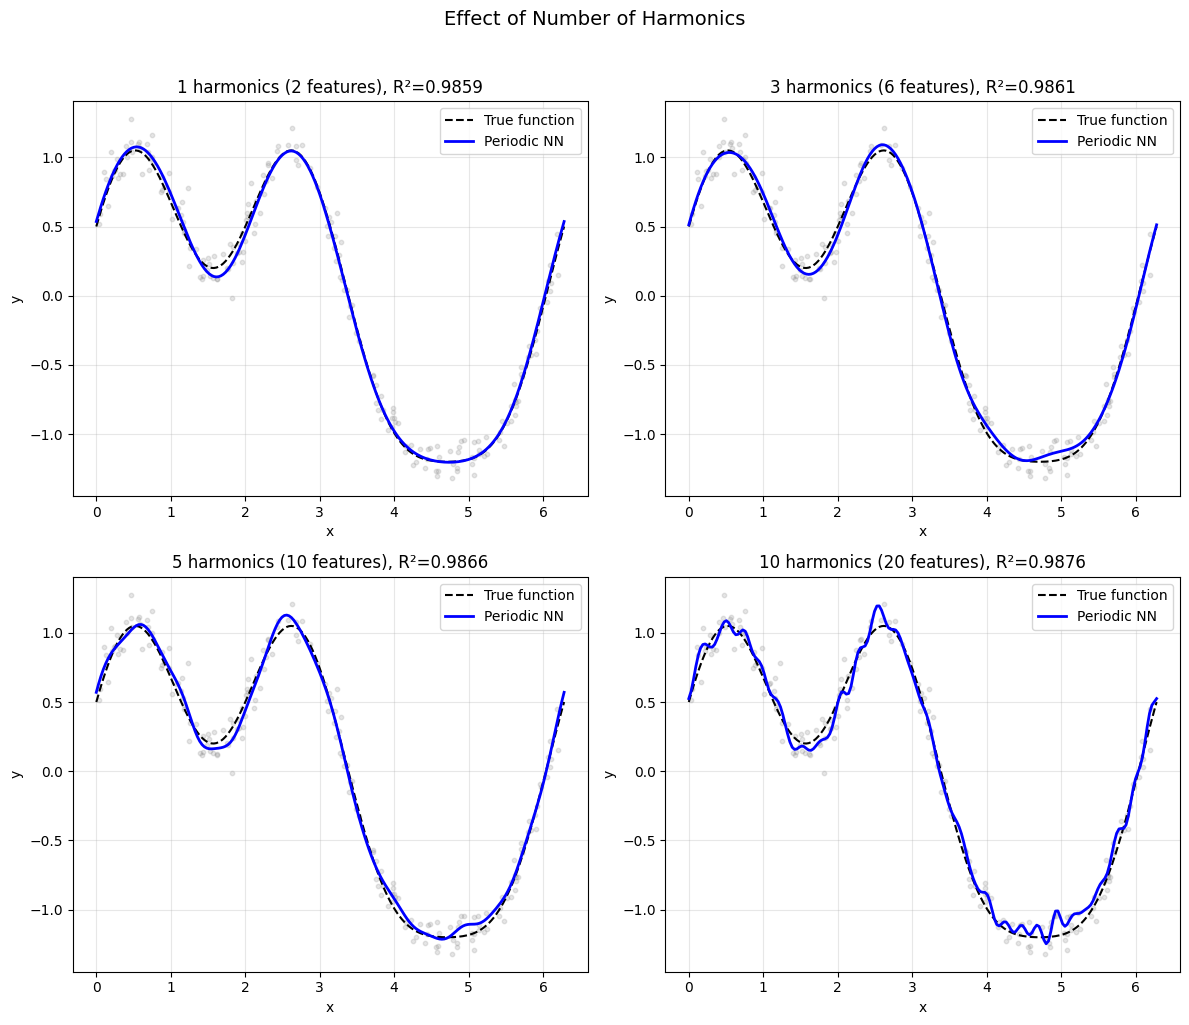

More harmonics = better fit for complex patterns
But also more parameters (potential overfitting with limited data)


In [8]:
# Compare different numbers of harmonics
X_plot = np.linspace(0, 2 * np.pi, 200).reshape(-1, 1)
y_true_complex = (
    np.sin(X_plot[:, 0]) + 0.5 * np.cos(2 * X_plot[:, 0]) + 0.3 * np.sin(3 * X_plot[:, 0])
)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, n_harm in zip(axes.flat, [1, 3, 5, 10]):
    y_pred = models[n_harm].predict(X_plot)

    ax.plot(X_plot, y_true_complex, "k--", linewidth=1.5, label="True function")
    ax.plot(X_plot, y_pred, "b-", linewidth=2, label="Periodic NN")
    ax.scatter(X_complex, y_complex, alpha=0.2, c="gray", s=10)

    r2 = models[n_harm].score(X_complex, y_complex)
    n_features = models[n_harm].n_expanded_features_
    ax.set_title(f"{n_harm} harmonics ({n_features} features), R²={r2:.4f}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle("Effect of Number of Harmonics", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("More harmonics = better fit for complex patterns")
print("But also more parameters (potential overfitting with limited data)")

## 3. Mixed Periodic and Non-Periodic Features

In many applications, some features are periodic (like angles) while others are not (like temperature or pressure).

In [9]:
# Generate data with mixed features
# Example: Material property as function of angle (periodic) and temperature (non-periodic)
np.random.seed(42)
n_samples = 300

angle = np.random.uniform(0, 2 * np.pi, n_samples)  # Periodic
temperature = np.random.uniform(300, 600, n_samples)  # Non-periodic (Kelvin)

X_mixed = np.column_stack([angle, temperature])

# Property depends on both:
# - Periodic in angle (e.g., crystallographic orientation)
# - Linear in temperature
y_mixed = (
    np.cos(angle)  # Periodic dependence
    + 0.01 * (temperature - 450)  # Linear temperature dependence
    + 0.1 * np.random.randn(n_samples)
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_mixed, y_mixed, test_size=0.2, random_state=42
)

print("Features:")
print("  x0: Angle (radians) - PERIODIC with period 2π")
print("  x1: Temperature (K) - NON-PERIODIC")

Features:
  x0: Angle (radians) - PERIODIC with period 2π
  x1: Temperature (K) - NON-PERIODIC


In [10]:
# Train model with mixed periodicity
model_mixed = JAXPeriodicRegressor(
    hidden_dims=(32, 32),
    periodicity={0: 2 * np.pi},  # Only angle is periodic
    n_harmonics=3,
    epochs=500,
    random_state=42,
    verbose=True,
)
model_mixed.fit(X_train, y_train)

r2 = model_mixed.score(X_test, y_test)
print(f"\nR² score on test set: {r2:.4f}")
print(f"\nExpanded features: {model_mixed.n_expanded_features_}")
print("  Angle: 3 harmonics × 2 = 6 features")
print("  Temperature: 1 feature (unchanged)")
print("  Total: 7 features")

Epoch 100/500, Loss: 0.008165
Epoch 200/500, Loss: 0.007405
Epoch 300/500, Loss: 0.007404
Epoch 400/500, Loss: 0.006808
Epoch 500/500, Loss: 0.007693
LLPR calibrated: α²=6.95e-02, ζ²=1.00e-08, NLL=-0.8520

R² score on test set: 0.9861

Expanded features: 7
  Angle: 3 harmonics × 2 = 6 features
  Temperature: 1 feature (unchanged)
  Total: 7 features


In [11]:
# Verify periodicity in angle but not in temperature
print("Periodicity verification:")

# Test periodicity in angle
x_base = np.array([[0.5, 400.0], [1.0, 400.0], [2.0, 400.0]])
x_shifted = x_base.copy()
x_shifted[:, 0] += 2 * np.pi  # Shift angle by one period

y_base = model_mixed.predict(x_base)
y_shifted = model_mixed.predict(x_shifted)

print("\n1. Shifting angle by 2π (should give identical predictions):")
for i in range(len(x_base)):
    print(
        f"   angle={x_base[i, 0]:.2f}: f={y_base[i]:.4f}, f(angle+2π)={y_shifted[i]:.4f}, diff={abs(y_base[i] - y_shifted[i]):.2e}"
    )

# Test non-periodicity in temperature
x_temp1 = np.array([[1.0, 300.0]])
x_temp2 = np.array([[1.0, 500.0]])

y_temp1 = model_mixed.predict(x_temp1)
y_temp2 = model_mixed.predict(x_temp2)

print("\n2. Changing temperature (should give DIFFERENT predictions):")
print(f"   T=300K: f={y_temp1[0]:.4f}")
print(f"   T=500K: f={y_temp2[0]:.4f}")
print(f"   Difference: {abs(y_temp1[0] - y_temp2[0]):.4f} (expected ~2.0)")

Periodicity verification:

1. Shifting angle by 2π (should give identical predictions):
   angle=0.50: f=0.4964, f(angle+2π)=0.4964, diff=1.67e-16
   angle=1.00: f=0.0449, f(angle+2π)=0.0449, diff=6.25e-17
   angle=2.00: f=-0.8772, f(angle+2π)=-0.8772, diff=2.22e-16

2. Changing temperature (should give DIFFERENT predictions):
   T=300K: f=-1.0393
   T=500K: f=0.9871
   Difference: 2.0265 (expected ~2.0)


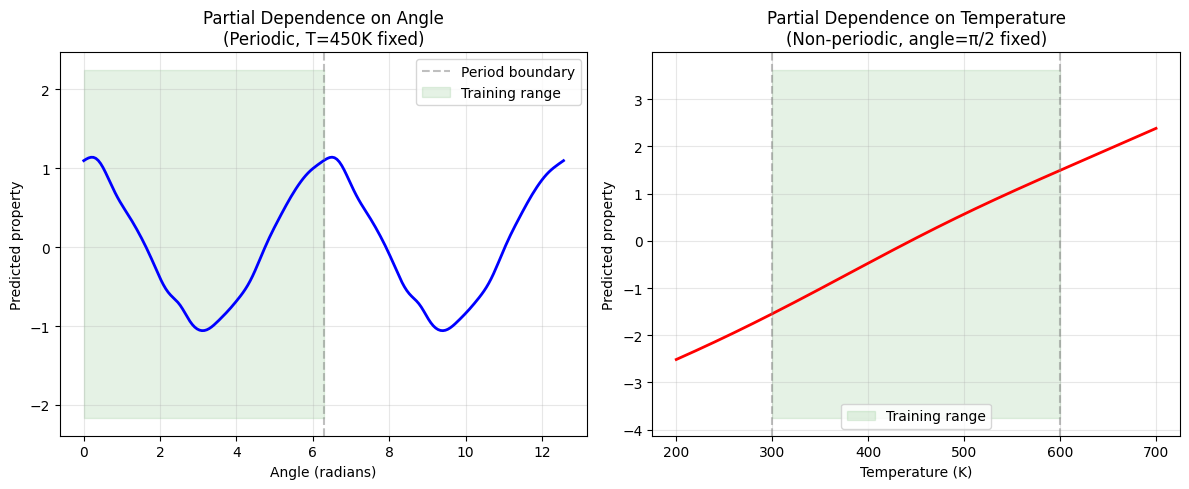

In [12]:
# Visualize partial dependencies
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Partial dependence on angle (at fixed temperature)
angles_plot = np.linspace(0, 4 * np.pi, 200)
X_angle = np.column_stack([angles_plot, np.full(200, 450)])
y_angle = model_mixed.predict(X_angle)

ax = axes[0]
ax.plot(angles_plot, y_angle, "b-", linewidth=2)
ax.axvline(2 * np.pi, color="gray", linestyle="--", alpha=0.5, label="Period boundary")
ax.fill_between(
    [0, 2 * np.pi],
    ax.get_ylim()[0] - 1,
    ax.get_ylim()[1] + 1,
    alpha=0.1,
    color="green",
    label="Training range",
)
ax.set_xlabel("Angle (radians)")
ax.set_ylabel("Predicted property")
ax.set_title("Partial Dependence on Angle\n(Periodic, T=450K fixed)")
ax.legend()
ax.grid(True, alpha=0.3)

# Partial dependence on temperature (at fixed angle)
temps_plot = np.linspace(200, 700, 200)
X_temp = np.column_stack([np.full(200, np.pi / 2), temps_plot])
y_temp = model_mixed.predict(X_temp)

ax = axes[1]
ax.plot(temps_plot, y_temp, "r-", linewidth=2)
ax.axvline(300, color="gray", linestyle="--", alpha=0.5)
ax.axvline(600, color="gray", linestyle="--", alpha=0.5)
ax.fill_between(
    [300, 600],
    ax.get_ylim()[0] - 1,
    ax.get_ylim()[1] + 1,
    alpha=0.1,
    color="green",
    label="Training range",
)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Predicted property")
ax.set_title("Partial Dependence on Temperature\n(Non-periodic, angle=π/2 fixed)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Uncertainty Quantification with LLPR

The `JAXPeriodicRegressor` includes **Last-Layer Prediction Rigidity (LLPR)** for uncertainty quantification. This provides calibrated uncertainty estimates.

The uncertainty formula:
$$\sigma^2_* = \alpha^2 f_*^T (F^T F + \zeta^2 I)^{-1} f_*$$

where $f_*$ is the last-layer feature vector and $F$ is the matrix of training features.

In [13]:
# Predict with uncertainty
X_test_unc = np.linspace(0, 4 * np.pi, 100).reshape(-1, 1)
y_pred_unc, y_std_unc = model.predict_with_uncertainty(X_test_unc)

print(f"Predictions shape: {y_pred_unc.shape}")
print(f"Uncertainties shape: {y_std_unc.shape}")
print(f"\nMean uncertainty: {np.mean(y_std_unc):.4f}")
print(f"Uncertainty range: [{y_std_unc.min():.4f}, {y_std_unc.max():.4f}]")

Predictions shape: (100,)
Uncertainties shape: (100,)

Mean uncertainty: 0.0572
Uncertainty range: [0.0442, 0.0833]


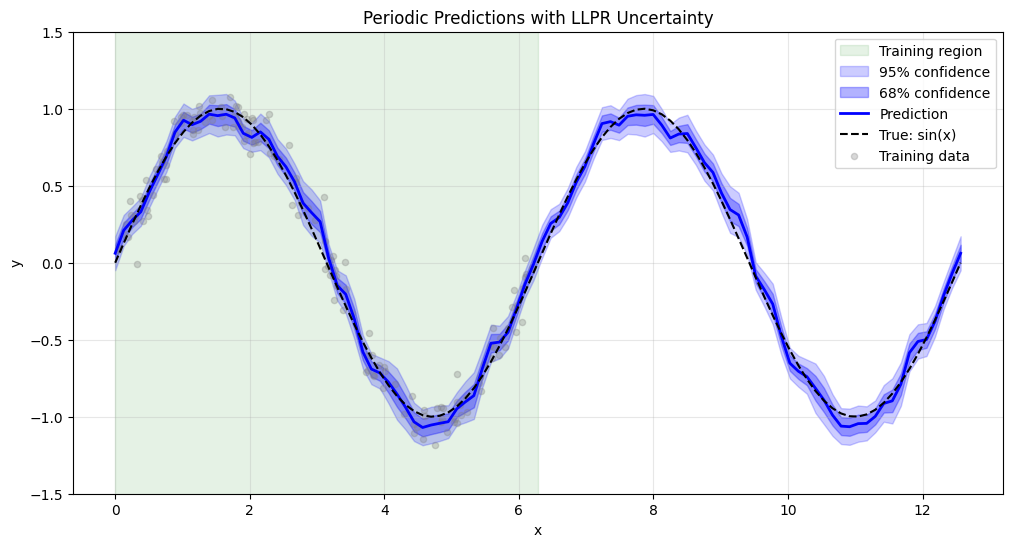

Key observation: Uncertainty is consistent across all periods!
This is because the Fourier features have the same values at equivalent phase points.


In [14]:
# Visualize predictions with uncertainty bands
plt.figure(figsize=(12, 6))

# Training region
plt.fill_between([0, 2 * np.pi], -2, 2, alpha=0.1, color="green", label="Training region")

# Confidence intervals
plt.fill_between(
    X_test_unc.ravel(),
    y_pred_unc - 2 * y_std_unc,
    y_pred_unc + 2 * y_std_unc,
    alpha=0.2,
    color="blue",
    label="95% confidence",
)
plt.fill_between(
    X_test_unc.ravel(),
    y_pred_unc - y_std_unc,
    y_pred_unc + y_std_unc,
    alpha=0.3,
    color="blue",
    label="68% confidence",
)

# Mean prediction
plt.plot(X_test_unc, y_pred_unc, "b-", linewidth=2, label="Prediction")

# True function
plt.plot(X_test_unc, np.sin(X_test_unc), "k--", linewidth=1.5, label="True: sin(x)")

# Data
plt.scatter(X_train_range, y_train_range, alpha=0.3, c="gray", s=20, label="Training data")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Periodic Predictions with LLPR Uncertainty")
plt.legend(loc="upper right")
plt.ylim(-1.5, 1.5)
plt.grid(True, alpha=0.3)
plt.show()

print("Key observation: Uncertainty is consistent across all periods!")
print("This is because the Fourier features have the same values at equivalent phase points.")

In [15]:
# Compare uncertainty at equivalent phase points
x_points = np.array([[0.5], [0.5 + 2 * np.pi], [0.5 + 4 * np.pi]])
y_pred_pts, y_std_pts = model.predict_with_uncertainty(x_points)

print("Uncertainty at equivalent phase points:")
print("\n  x          y_pred     std")
print("  " + "-" * 30)
for i, x in enumerate(x_points):
    print(f"  {x[0]:8.4f}   {y_pred_pts[i]:8.4f}   {y_std_pts[i]:.6f}")

print("\nUncertainties are identical at equivalent phases (as expected)!")

Uncertainty at equivalent phase points:

  x          y_pred     std
  ------------------------------
    0.5000     0.4515   0.049678
    6.7832     0.4515   0.049678
   13.0664     0.4515   0.049678

Uncertainties are identical at equivalent phases (as expected)!


## 5. Application: Dihedral Angle Energy Surface

A common application in computational chemistry: the potential energy as a function of a dihedral angle (torsion angle). This is inherently periodic with period $2\pi$ (or sometimes $\pi$ for symmetric molecules).

In [16]:
# Simulate dihedral angle energy data
# This mimics a typical torsional potential (e.g., ethane rotation)
np.random.seed(42)
n_samples = 100

# Dihedral angles sampled sparsely
phi = np.random.uniform(-np.pi, np.pi, n_samples)


# Ryckaert-Bellemans type potential (common for torsions)
# V(φ) = Σ Cn cos^n(φ)
def torsion_potential(phi):
    return (
        2.0 * (1 - np.cos(phi))  # V1 term (1-fold)
        + 1.0 * (1 - np.cos(3 * phi))  # V3 term (3-fold, common for sp3 carbons)
        + 0.2 * (1 - np.cos(2 * phi))  # V2 term (2-fold)
    )


y_energy = torsion_potential(phi) + 0.1 * np.random.randn(n_samples)
X_phi = phi.reshape(-1, 1)

print("Dihedral angle energy surface:")
print(f"  Training samples: {n_samples}")
print("  Angle range: [-π, π]")
print("  Period: 2π")

Dihedral angle energy surface:
  Training samples: 100
  Angle range: [-π, π]
  Period: 2π


In [17]:
# Train periodic model for dihedral energy
model_dihedral = JAXPeriodicRegressor(
    hidden_dims=(32, 32),
    periodicity={0: 2 * np.pi},
    n_harmonics=5,  # Enough to capture V1, V2, V3 terms
    epochs=500,
    random_state=42,
)
model_dihedral.fit(X_phi, y_energy)

print(f"R² score: {model_dihedral.score(X_phi, y_energy):.4f}")

R² score: 0.9973


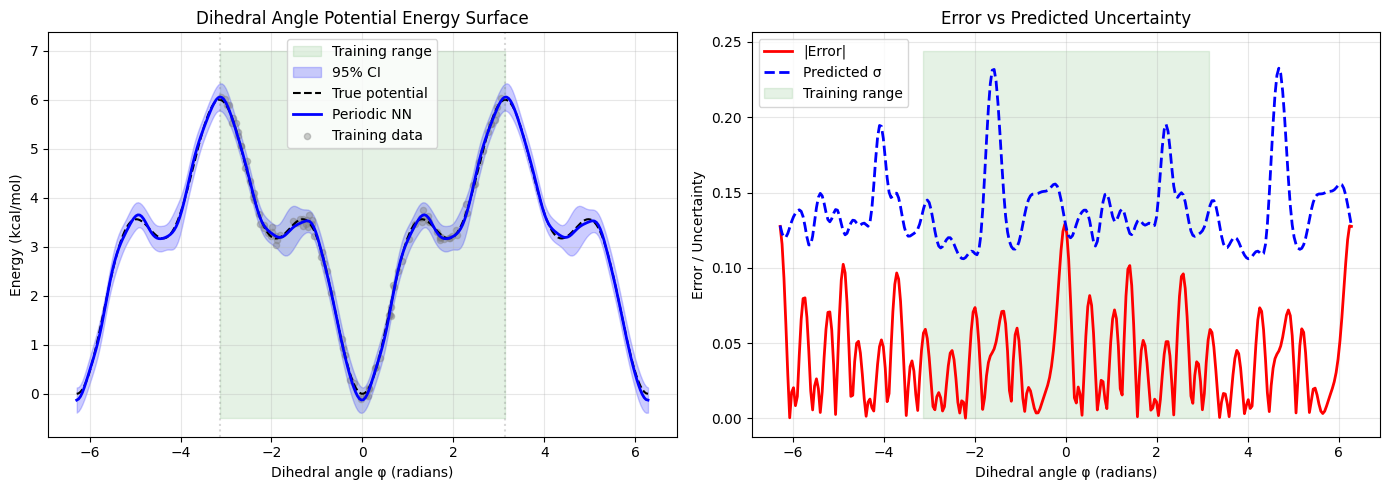

The model perfectly captures the periodic nature of the torsional potential!


In [18]:
# Visualize the learned potential energy surface
phi_plot = np.linspace(-2 * np.pi, 2 * np.pi, 300).reshape(-1, 1)
y_pred_dihedral, y_std_dihedral = model_dihedral.predict_with_uncertainty(phi_plot)
y_true_dihedral = torsion_potential(phi_plot[:, 0])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Energy surface
ax = axes[0]
ax.fill_between([-np.pi, np.pi], -0.5, 7, alpha=0.1, color="green", label="Training range")
ax.fill_between(
    phi_plot.ravel(),
    y_pred_dihedral - 2 * y_std_dihedral,
    y_pred_dihedral + 2 * y_std_dihedral,
    alpha=0.2,
    color="blue",
    label="95% CI",
)
ax.plot(phi_plot, y_true_dihedral, "k--", linewidth=1.5, label="True potential")
ax.plot(phi_plot, y_pred_dihedral, "b-", linewidth=2, label="Periodic NN")
ax.scatter(X_phi, y_energy, alpha=0.4, c="gray", s=20, label="Training data")
ax.axvline(-np.pi, color="gray", linestyle=":", alpha=0.3)
ax.axvline(np.pi, color="gray", linestyle=":", alpha=0.3)
ax.set_xlabel("Dihedral angle φ (radians)")
ax.set_ylabel("Energy (kcal/mol)")
ax.set_title("Dihedral Angle Potential Energy Surface")
ax.legend()
ax.grid(True, alpha=0.3)

# Error and uncertainty
ax = axes[1]
error = np.abs(y_pred_dihedral - y_true_dihedral)
ax.plot(phi_plot, error, "r-", linewidth=2, label="|Error|")
ax.plot(phi_plot, y_std_dihedral, "b--", linewidth=2, label="Predicted σ")
ax.fill_between(
    [-np.pi, np.pi],
    0,
    ax.get_ylim()[1] if ax.get_ylim()[1] > 0 else 1,
    alpha=0.1,
    color="green",
    label="Training range",
)
ax.set_xlabel("Dihedral angle φ (radians)")
ax.set_ylabel("Error / Uncertainty")
ax.set_title("Error vs Predicted Uncertainty")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("The model perfectly captures the periodic nature of the torsional potential!")

## 6. Comparison: Periodic vs Non-Periodic Model

Let's see what happens when we ignore the periodic nature of the data.

In [19]:
# Train models with and without periodicity
model_periodic = JAXPeriodicRegressor(
    hidden_dims=(32, 32),
    periodicity={0: 2 * np.pi},
    n_harmonics=5,
    epochs=500,
    random_state=42,
)

model_nonperiodic = JAXPeriodicRegressor(
    hidden_dims=(32, 32),
    periodicity=None,  # No periodicity
    epochs=500,
    random_state=42,
)

# Train on limited range
model_periodic.fit(X_train_range, y_train_range)
model_nonperiodic.fit(X_train_range, y_train_range)

print("Training on [0, 2π]:")
print(f"  Periodic model R²:     {model_periodic.score(X_train_range, y_train_range):.4f}")
print(f"  Non-periodic model R²: {model_nonperiodic.score(X_train_range, y_train_range):.4f}")

Training on [0, 2π]:
  Periodic model R²:     0.9842
  Non-periodic model R²: 0.9801


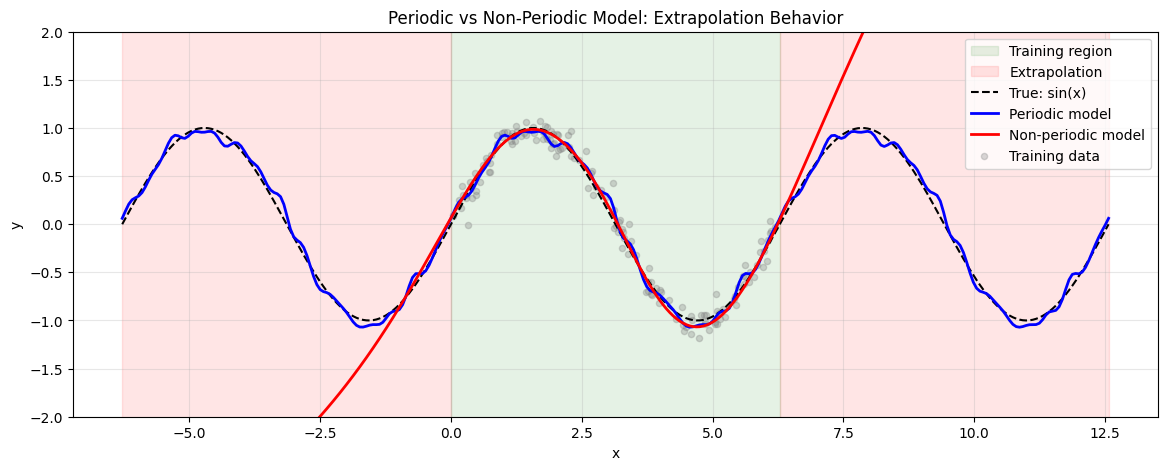

Extrapolation RMSE:
  Periodic model:     0.0585
  Non-periodic model: 3.5187

The periodic model extrapolates 60x better!


In [20]:
# Compare extrapolation
X_extrap = np.linspace(-2 * np.pi, 4 * np.pi, 300).reshape(-1, 1)
y_periodic = model_periodic.predict(X_extrap)
y_nonperiodic = model_nonperiodic.predict(X_extrap)
y_true = np.sin(X_extrap[:, 0])

plt.figure(figsize=(14, 5))

# Mark regions
plt.fill_between([0, 2 * np.pi], -3, 3, alpha=0.1, color="green", label="Training region")
plt.fill_between([-2 * np.pi, 0], -3, 3, alpha=0.1, color="red", label="Extrapolation")
plt.fill_between([2 * np.pi, 4 * np.pi], -3, 3, alpha=0.1, color="red")

plt.plot(X_extrap, y_true, "k--", linewidth=1.5, label="True: sin(x)")
plt.plot(X_extrap, y_periodic, "b-", linewidth=2, label="Periodic model")
plt.plot(X_extrap, y_nonperiodic, "r-", linewidth=2, label="Non-periodic model")
plt.scatter(X_train_range, y_train_range, alpha=0.3, c="gray", s=20, label="Training data")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Periodic vs Non-Periodic Model: Extrapolation Behavior")
plt.legend(loc="upper right")
plt.ylim(-2, 2)
plt.grid(True, alpha=0.3)
plt.show()

# Compute extrapolation error
extrap_mask = (X_extrap[:, 0] < 0) | (X_extrap[:, 0] > 2 * np.pi)
rmse_periodic = np.sqrt(np.mean((y_periodic[extrap_mask] - y_true[extrap_mask]) ** 2))
rmse_nonperiodic = np.sqrt(np.mean((y_nonperiodic[extrap_mask] - y_true[extrap_mask]) ** 2))

print("Extrapolation RMSE:")
print(f"  Periodic model:     {rmse_periodic:.4f}")
print(f"  Non-periodic model: {rmse_nonperiodic:.4f}")
print(f"\nThe periodic model extrapolates {rmse_nonperiodic / rmse_periodic:.0f}x better!")

## 7. Learnable Periods

In many applications, the exact period is not known in advance. `JAXPeriodicRegressor` supports
**learning the period from data** when `learn_period=True`.

### How it Works

When periods are learnable:
1. Periods are parameterized using softplus to ensure positivity: $T = \text{softplus}(T_{raw}) = \log(1 + e^{T_{raw}})$
2. A regularization term encourages periods to stay near initial guesses: $L_{reg} = \lambda \sum_i (T_i - T_i^{init})^2$
3. Both network weights and periods are optimized jointly during training

### When to Use Learnable Periods

- **Unknown period**: When the exact period is not known but you have a rough estimate
- **Multiple components**: When the data has multiple periodic components with unknown frequencies
- **Period estimation**: When discovering the period is itself the goal

In [21]:
# Example: Discover the true period from data
np.random.seed(42)

# Generate data with TRUE period of 5.0 (pretend we don't know this)
true_period = 5.0
n_samples = 150

X_learn = np.random.uniform(0, 15, (n_samples, 1))  # Sample over ~3 periods
y_learn = np.sin(2 * np.pi * X_learn[:, 0] / true_period) + 0.1 * np.random.randn(n_samples)

print(f"True period: {true_period}")
print(f"Training samples: {n_samples}")
print("Training range: [0, 15] (~3 periods)")

# Start with an incorrect initial guess
initial_guess = 6.0  # Wrong by 20%
print(f"\nInitial period guess: {initial_guess} (20% error)")

# Train with learnable period
model_learn = JAXPeriodicRegressor(
    hidden_dims=(32, 32),
    periodicity={0: initial_guess},  # Initial guess
    n_harmonics=5,
    epochs=500,
    learn_period=True,
    period_reg=0.01,  # Low regularization allows period to change more
    random_state=42,
    verbose=True,
)
model_learn.fit(X_learn, y_learn)

learned_period = model_learn.learned_periods_[0]
print(f"\nLearned period: {learned_period:.4f}")
print(f"True period: {true_period}")
print(f"Error: {100 * abs(learned_period - true_period) / true_period:.2f}%")

True period: 5.0
Training samples: 150
Training range: [0, 15] (~3 periods)

Initial period guess: 6.0 (20% error)
Epoch 100/500, Loss: 0.030864, Periods: {0:5.0215}
Epoch 200/500, Loss: 0.028494, Periods: {0:4.9984}
Epoch 300/500, Loss: 0.028734, Periods: {0:4.9960}
Epoch 400/500, Loss: 0.028450, Periods: {0:4.9956}
Epoch 500/500, Loss: 0.028118, Periods: {0:4.9967}
LLPR calibrated: α²=6.95e-02, ζ²=2.07e-02, NLL=-0.8661

Learned period: 4.9967
True period: 5.0
Error: 0.07%


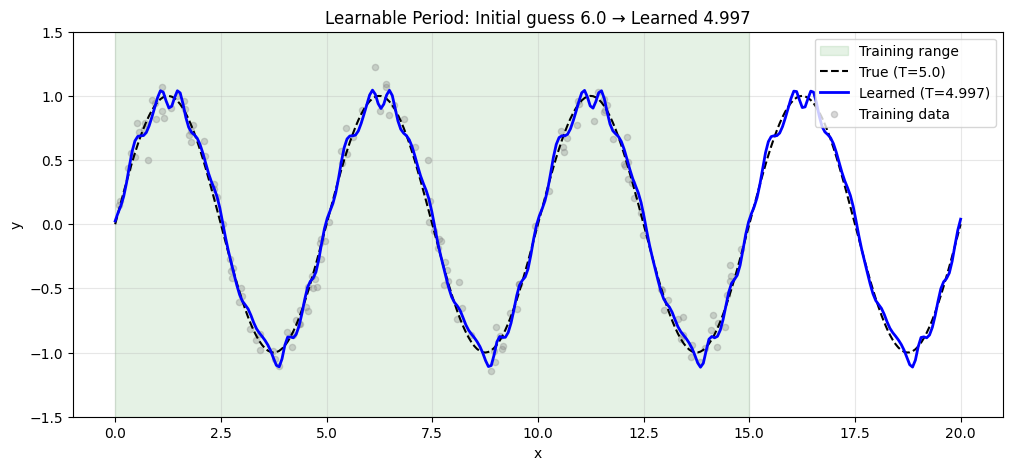

Starting with 6.0, the model learned 4.997 (true: 5.0)


In [22]:
# Visualize the learned vs true period
X_plot = np.linspace(0, 20, 300).reshape(-1, 1)
y_pred_learn = model_learn.predict(X_plot)
y_true_learn = np.sin(2 * np.pi * X_plot[:, 0] / true_period)

plt.figure(figsize=(12, 5))

plt.fill_between([0, 15], -1.5, 1.5, alpha=0.1, color="green", label="Training range")
plt.plot(X_plot, y_true_learn, "k--", linewidth=1.5, label=f"True (T={true_period})")
plt.plot(X_plot, y_pred_learn, "b-", linewidth=2, label=f"Learned (T={learned_period:.3f})")
plt.scatter(X_learn, y_learn, alpha=0.3, c="gray", s=20, label="Training data")

plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Learnable Period: Initial guess {initial_guess:.1f} → Learned {learned_period:.3f}")
plt.legend()
plt.ylim(-1.5, 1.5)
plt.grid(True, alpha=0.3)
plt.show()

print(
    f"Starting with {initial_guess:.1f}, the model learned {learned_period:.3f} (true: {true_period:.1f})"
)

In [23]:
# Compare effect of regularization strength
regularizations = [0.001, 0.01, 0.1, 1.0]
learned_periods_reg = {}

for reg in regularizations:
    model_reg = JAXPeriodicRegressor(
        hidden_dims=(32, 32),
        periodicity={0: initial_guess},
        n_harmonics=5,
        epochs=300,
        learn_period=True,
        period_reg=reg,
        random_state=42,
    )
    model_reg.fit(X_learn, y_learn)
    learned_periods_reg[reg] = model_reg.learned_periods_[0]

print("Effect of regularization (period_reg):")
print("\n  period_reg   Learned Period   Error")
print("  " + "-" * 40)
for reg, learned in learned_periods_reg.items():
    error = 100 * abs(learned - true_period) / true_period
    print(f"  {reg:8.3f}      {learned:8.4f}       {error:5.2f}%")

print(f"\n  (True period: {true_period})")
print("\nLower regularization allows more deviation from initial guess.")

Effect of regularization (period_reg):

  period_reg   Learned Period   Error
  ----------------------------------------
     0.001        4.9845        0.31%
     0.010        4.9960        0.08%
     0.100        5.1201        2.40%
     1.000        5.7634       15.27%

  (True period: 5.0)

Lower regularization allows more deviation from initial guess.


## 8. sklearn Compatibility

`JAXPeriodicRegressor` is fully compatible with sklearn's API.

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Create a pipeline (note: StandardScaler only applies to non-periodic features)
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "model",
            JAXPeriodicRegressor(
                hidden_dims=(16, 16),
                epochs=100,
                periodicity={0: 2 * np.pi},
                n_harmonics=3,
                standardize_X=False,  # Don't double-standardize
            ),
        ),
    ]
)

# Cross-validation
scores = cross_val_score(pipe, X_train_range, y_train_range, cv=3, scoring="r2")
print(f"Cross-validation R² scores: {scores}")
print(f"Mean R²: {scores.mean():.4f} (+/- {scores.std():.4f})")

Cross-validation R² scores: [0.98050077 0.9793102  0.97373476]
Mean R²: 0.9778 (+/- 0.0029)


In [25]:
# Get/set parameters
model = JAXPeriodicRegressor(periodicity={0: 2 * np.pi}, n_harmonics=5, epochs=100)
params = model.get_params()
print("Model parameters:")
for k, v in params.items():
    print(f"  {k}: {v}")

Model parameters:
  activation: silu
  alpha_squared: auto
  batch_size: 32
  epochs: 100
  hidden_dims: (32, 32)
  learn_period: False
  learning_rate: 0.005
  n_harmonics: 5
  period_reg: 0.1
  periodicity: {0: 6.283185307179586}
  random_state: 42
  standardize_X: True
  standardize_y: True
  val_size: 0.1
  verbose: False
  weight_decay: 0.0
  zeta_squared: auto


## Summary

**JAXPeriodicRegressor** provides a sklearn-compatible implementation of periodic neural networks with:

### Key Features:
- **Exact periodicity**: f(x + T) = f(x) is guaranteed by construction
- **Fourier expansion**: Captures complex periodic patterns with harmonics
- **Mixed features**: Some features can be periodic, others not
- **Learnable periods**: Optionally learn periods from data
- **LLPR uncertainty**: Calibrated uncertainty estimates
- **sklearn API**: Works with pipelines, cross-validation, etc.

### When to Use:
1. **Periodic inputs**: Angles, phases, cyclic time features
2. **Perfect extrapolation**: When you need predictions outside the training range
3. **Physical constraints**: When periodicity is a known property
4. **Computational chemistry**: Dihedral angles, crystallographic orientations
5. **Unknown periods**: When the period needs to be learned from data

### Parameters:
- `periodicity`: Dict mapping feature indices to periods (e.g., {0: 2π})
- `n_harmonics`: Number of Fourier harmonics (default: 5)
- `hidden_dims`: Network architecture (default: (32, 32))
- `activation`: "silu", "softplus", "relu", or "tanh" (default: silu)
- `learn_period`: Whether to learn periods from data (default: False)
- `period_reg`: Regularization strength for learnable periods (default: 0.1)
- `alpha_squared/zeta_squared`: LLPR calibration (default: 'auto')

### Methods:
- `fit(X, y)`: Train the model
- `predict(X)`: Make predictions
- `predict_with_uncertainty(X)`: Get (predictions, std)
- `get_fourier_features(X)`: Inspect expanded features
- `score(X, y)`: Compute R² score

### Attributes (after fitting):
- `learned_periods_`: Dict of learned periods (when `learn_period=True`)